In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from collections import deque

from tqdm.notebook import trange

import gymnasium as gym


In [24]:
N_EPISODES = 1_800              # Number of episodes to run for training 
MEMORY_BUFFER = 100_000         # Experience memory size  
BATCH_SIZE = 64                 # Batch size for neural network training 
UPDATE_STEP = 4                 # Number of steps to update target model

TAU =  0.005                    # Parameter for the soft update of the weights 
GAMMA = 0.995                    # Discount factor for the calculation of the return 

N_ACTIONS = 4              # Number of possible actions  (0: NOOP, 1: FIRE, 2: RIGHT, 3: LEFT)

EPSILON_INTERVALS = [(400, 1.), (800, .9), (1_000, .8), (1_200, .7), (1_400, .6), (1_800, .5), (2_200, .4), (2_600, .3), (3_000, .2), (3_400, .1), (3_800, .05), (4_000, .025)]

In [25]:
def get_epsilon(episode):

    for l, e in EPSILON_INTERVALS:
        if episode <= l:
            return e
    return 0

In [26]:
# Network architecture:
#   The original paper is https://arxiv.org/pdf/1312.5602 
#   but I use the keras example instead https://keras.io/examples/rl/deep_q_network_breakout/ instead
#
#   The network in the paper is simpler:
#       Input: (4, 84, 84)
#       Convolution: valid, f=8, s=4, 16 filters -> (16, 20, 20)
#       Convolution: valid, f=4, s=2, 32 filters -> (32, 9, 9)
#       Flatten: 
#       Dense: -> 256
#       Dense: -> 4

def q_model():

    return keras.Sequential ([
            keras.layers.Input(shape=(4, 84, 84)),
            keras.layers.Conv2D(32,(8, 8), data_format='channels_first', strides=4, activation='relu'),
            keras.layers.Conv2D(64,(4, 4), data_format='channels_first', strides=2, activation='relu'),
            keras.layers.Conv2D(64,(3, 3), data_format='channels_first', strides=2, activation='relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(4)
    ]) 

In [27]:
def get_samples(memory, sample_size):

  samples = random.sample(memory, sample_size)
  
  states, actions, states_next, rewards, terminated, truncated = zip(*samples)

  states = np.stack(states, axis=0)
  states_next = np.stack(states_next, axis=0)
  actions = np.array(actions, dtype='int32')
  rewards = np.array(rewards, dtype='float32')
  terminated = np.array(terminated, dtype='float32')

  return states, actions, states_next, rewards, terminated

In [28]:
# Train step

@tf.function
def train_step(samples, q_function, q_function_target, loss_function, optimizer):

  states, actions, states_next, rewards, terminated = samples

  # Use q_function_target to calculate Q(state_prime, action) used in Bellman equation
  max_qsa = tf.math.reduce_max(q_function_target(states_next, training=False), axis=1)

  # Bellman equation
  # For terminated states, q_value is just the reward
  qvalues_target = (rewards + (1 - terminated) * GAMMA * max_qsa)

  # Calculate mask so loss is calculated only on the action taken
  mask = tf.one_hot(actions, N_ACTIONS) 

  with tf.GradientTape() as tape:

    # Run model
    qvalues_predictions = tf.reduce_max(
      tf.multiply(q_function(states, training=True), mask), axis=1)

    # Calculate loss
    loss = loss_function(qvalues_target, qvalues_predictions)

  # Back propagation
  grads = tape.gradient(loss, q_function.trainable_variables)
  optimizer.apply_gradients(zip(grads, q_function.trainable_variables))

  return loss


In [29]:

# Taken from: https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

In [30]:
# rng for the environment and to reshuffle samples
rng = np.random.default_rng(seed=34)

env = gym.make("BreakoutNoFrameskip-v4")

# The AtariPreprocessing wrapper implements among others the following transformations,
#  - Frame skip (4)
#  - Resize to square image (resizes from the original 210x180 to 84x84)
#  - Grey scale
env = gym.wrappers.AtariPreprocessing(env)

# The game won't stop until the Fire action is taken, so the episode could run for ever.
# This wrapper signals truncated after the given timesteps, giving the agent the opportunity to 
# learn that.
env = gym.wrappers.TimeLimit(env, max_episode_steps=1000)

# The FrameStack wrapper stacks n observations (4) in a rolling manner
env = gym.wrappers.FrameStack(env, 4)

env.np_random = rng

In [31]:
env.observation_space

Box(0, 255, (4, 84, 84), uint8)

In [32]:
# Model used to select actions. Gets updated every batch
q_function = q_model()

# Model used to calculate the rewards for the future predictions that are used
# in the Bellman equation used as target for the updates of q_function. It is a different
# one for stability. Gets updated every UPDATE_STEP
q_function_target = q_model()
q_function_target.set_weights(q_function.get_weights())

loss_function = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam()

In [33]:
q_function.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 20, 20)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 9, 9)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 4, 4)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,836 (2.31 MB)

 Trainable params: 604,836 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:

memory = deque(maxlen=MEMORY_BUFFER) 
loss_hist = []
reward_hist = []
duration_hist = []
step = 0
episode_reward = 0      # To accumulate the rewards of the episode
episode_duration = 0    # To keep a step count for the episode

for episode in trange(N_EPISODES, desc="Episode"):

    state, _ = env.reset()
    terminated = False
    truncated = False

    epsilon = get_epsilon(episode)

    while not (terminated or truncated):
        # take action using e-greedy selection
        if rng.choice([True, False], p=[epsilon, 1 - epsilon]): 
            action = rng.choice(N_ACTIONS)
        else:
            # Use Q function to select next action
            state_input = np.expand_dims(state, axis=0)
            qvalue_predictions = q_function(state_input, training=False)

            action = np.argmax(qvalue_predictions[0])

        state_next, reward, terminated, truncated, _ = env.step(action)

        memory.append((state, action, state_next, reward, terminated, truncated))

        update = (step + 1 >= BATCH_SIZE) and not ((step + 1) % UPDATE_STEP)
        if update:
            #
            # Update q-function
            #

            samples = get_samples(memory, BATCH_SIZE)

            # Train network
            loss = train_step(samples, q_function, q_function_target, loss_function, optimizer)
            
            loss_hist.append(loss.numpy())

            # Update target model
            new_weights = []
            for new_w, old_w in zip(q_function.get_weights(), q_function_target.get_weights()):
                new_weights.append(TAU * new_w + (1 - TAU) * old_w)

            q_function_target.set_weights(new_weights)

        step += 1
        episode_duration += 1
        episode_reward += reward
        if terminated or truncated:
            # Experiment ended, reset the environment
            reward_hist.append(episode_reward)
            duration_hist.append(episode_duration)
            episode_reward = 0
            episode_duration = 0
        else:
            state = state_next

Episode:   0%|          | 0/1800 [00:00<?, ?it/s]

<Axes: >

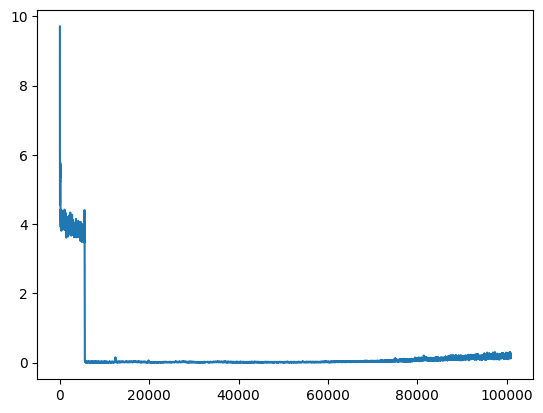

In [35]:
loss_df = pd.Series(loss_hist)
loss_df.rolling(window=20).mean().plot()

In [36]:

df_episodes = pd.DataFrame({
    "Reward": reward_hist,
    "Duration": duration_hist
    })


In [37]:
keras.saving.save_model(q_function, "q_function.keras")
df_episodes.to_pickle("./df_episodes.pkl")

array([[<Axes: >, <Axes: >]], dtype=object)

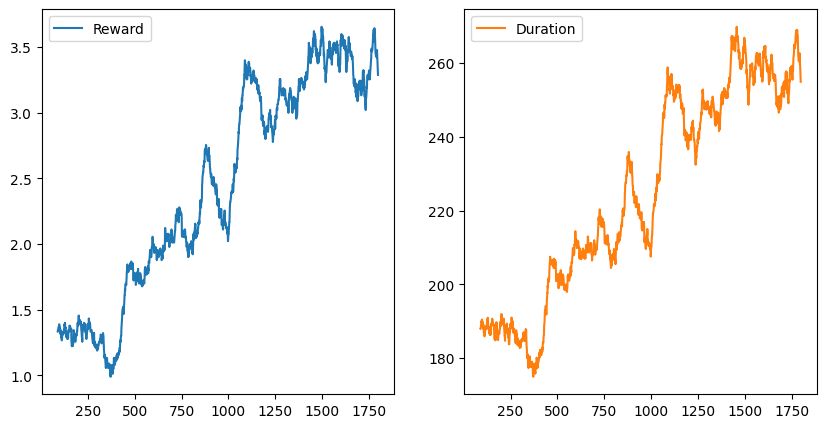

In [38]:

df_episodes = pd.read_pickle('./df_episodes.pkl')

df_episodes.rolling(window=90).mean().plot(subplots=True, layout=(1,2), figsize=(10, 5))

In [42]:

# Evaluation
q_function = keras.saving.load_model("q_function.keras")

rng = np.random.default_rng(seed=34)

env = gym.make("BreakoutNoFrameskip-v4")
env = gym.wrappers.AtariPreprocessing(env)
env = gym.wrappers.FrameStack(env, 4)

cumm_reward = 0
n = 10

for i in trange(n):
    state, _ = env.reset()
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        if rng.choice([True, False], p=[0.01, 0.99]): 
            # The game won't start until fire is pressed. This is to ensure 
            # it does (it may not have been learnt)
            action = 1
        else:
            state_input = np.expand_dims(state, axis=0)
            
            state_predictions = q_function(state_input, training=False)
            
            # take action using e-greedy selection    
            action = np.argmax(state_predictions[0])
        
        state, reward, terminated, truncated, _ = env.step(action)

        cumm_reward += reward

env.close()

print (f"Avg reward per episode {cumm_reward/n}")

  0%|          | 0/10 [00:00<?, ?it/s]

Avg reward per episode 3.0


In [43]:
#q_function = keras.saving.load_model("q_function.keras")

rng = np.random.default_rng(seed=34)

env = gym.make("BreakoutNoFrameskip-v4", render_mode='rgb_array')
env = gym.wrappers.AtariPreprocessing(env)
env = gym.wrappers.FrameStack(env, 4)
env = gym.wrappers.RecordVideo(env, "videos_atari", episode_trigger= lambda e: True)

# env.metadata['render_fps'] = 24

episodes_rewards = []

for i in trange(10):
    state, _ = env.reset()
    
    this_reward = []
    
    while True:
        if rng.choice([True, False], p=[0.01, 0.99]): 
            # The game won't start until fire is pressed. This is to ensure 
            # it does (it may not have been learnt)
            action = 1
        else:
            state_input = np.expand_dims(state, axis=0)
            state_predictions = q_function(state_input, training=False)
           
            action = np.argmax(state_predictions[0])
        
        state, reward, terminated, truncated, _ = env.step(action)
                
        this_reward.append(reward)

        if terminated or truncated:
            episodes_rewards.append(this_reward)

            break
    
df_rewards = pd.DataFrame(episodes_rewards).transpose()
env.close()

/home/damian/sandbox/atari/.venv/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/damian/sandbox/atari/videos_atari folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/home/damian/sandbox/atari/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-0.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-0.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-1.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-1.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-2.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-2.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-3.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-3.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-4.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-4.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-5.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-5.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-6.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-6.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-7.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-7.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-8.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-8.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos_atari/rl-video-episode-9.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos_atari/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos_atari/rl-video-episode-9.mp4


array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

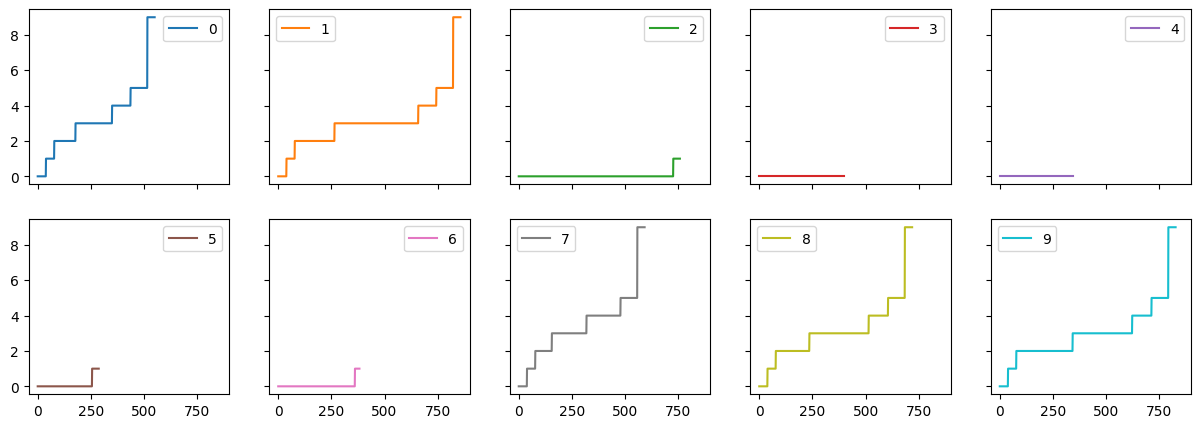

In [44]:

df_rewards.cumsum().plot(subplots=True, layout=(2,5), figsize=(15,5), sharey=True)